# Challenge: fit parameters to differential equation system

We have a (first order) biocatalytic reaction:

a <--> b

Which means that we have 2 different concentrations to be measured: **the substrate** and the **product**. 

## Target:

Fit parameters to the known model

<img src="./assets/worklfow_example_1.png">


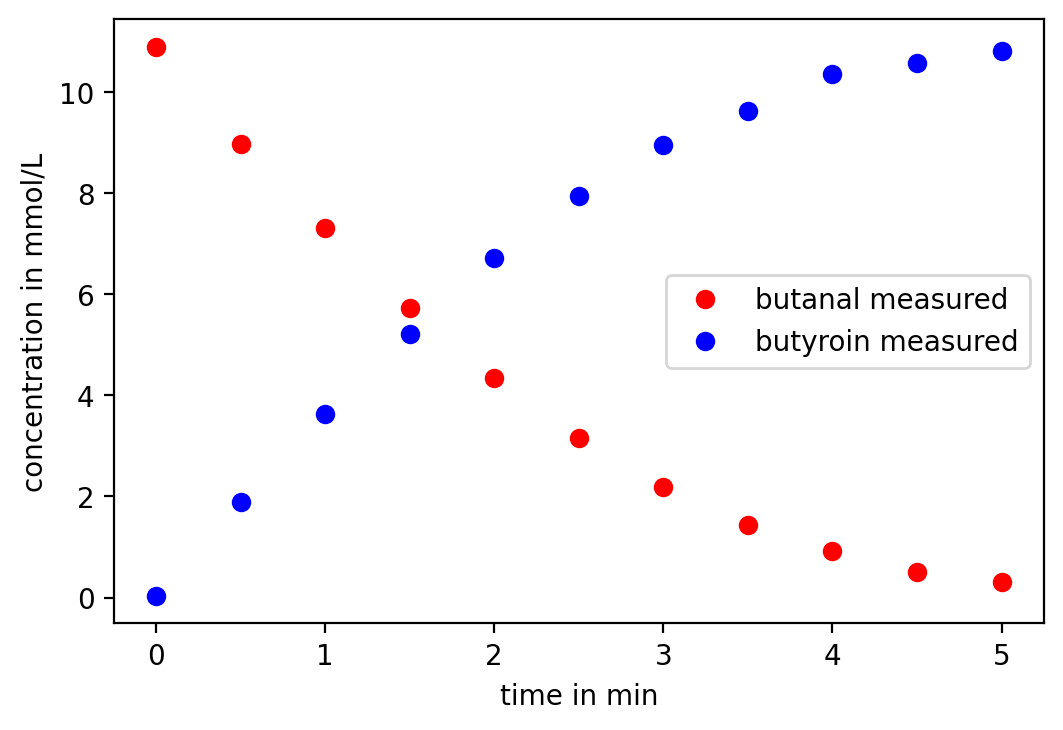

In [2]:
from scipy.integrate import odeint
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import lmfit

df = pd.read_excel(r"Full Conversion Approach.xlsx", sheet_name = "10mL_viualisation")
plt.rcParams["figure.dpi"] = 200

time = df["time in min"]
substrate = df["3-OH-BA"]
product = df["(S)-3-OH-PAC"]

time_before_feed = time.iloc[:11]
substrate_before_feed = substrate.iloc[:11]
product_before_feed = product.iloc[:11]
fix, ax = plt.subplots()
ax.plot(time_before_feed, substrate_before_feed, label="butanal measured", color="red", linestyle="", marker="o")
ax.plot(time_before_feed, product_before_feed, label="butyroin measured", color="blue", linestyle="", marker="o")
ax.set_xlabel("time in min")
ax.set_ylabel("concentration in mmol/L")
ax.legend()


In [10]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano

from pymc3.ode import DifferentialEquation
from scipy.integrate import odeint

plt.style.use("seaborn-darkgrid")

data_list = [substrate_before_feed,product_before_feed]

print(time_before_feed)


data = np.array(data_list)

y0_array = np.array([11, 0])
y0 = [20]

def dadt(y, t, p):
    dadt = -p[0]*y[0] + p[1]*y[1]
    dbdt = p[0]*y[1] - p[1]*y[1]
    #dadt = -p[0]*y[0] + p[1]*y[0]
    return [dadt, dbdt]



# test data

substrates = np.reshape(np.array(substrate_before_feed), (11, 1))
products = np.reshape(np.array(product_before_feed), (11, 1))
measured_data = np.column_stack((substrates,products))
times = np.array(time_before_feed)

# time array needs the shape (,11) and the data (11,1) 

ode_model = DifferentialEquation(func=dadt, times=times, n_states=2, n_theta=2)

with pm.Model() as model:
    # Specify prior distributions for soem of our model parameters
    Ka = pm.Uniform("Ka", 0, 1)
    #init = pm.Normal("init",11, 1)
    Kb = pm.Uniform("Kb", 0, 1)
    sigma = pm.Normal("sigma", 0.1)

    ode_solution = ode_model(y0=[11,0], theta=[Ka, Kb])

    Y = pm.Normal("Y", mu=ode_solution, sigma=sigma, observed=measured_data)

    prior = pm.sample_prior_predictive()
    trace = pm.sample(2000, tune=1000, cores=1)
    posterior_predictive = pm.sample_posterior_predictive(trace)

data = az.from_pymc3(trace=trace)

ode_solution_1 = ode_model(y0=[11,0], theta=[0.02, 0.00001])
print(ode_solution_1[0])


0     0.0
1     0.5
2     1.0
3     1.5
4     2.0
5     2.5
6     3.0
7     3.5
8     4.0
9     4.5
10    5.0
Name: time in min, dtype: float64


c:\Users\SMalz\anaconda3\lib\site-packages\ipykernel_launcher.py:53: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, Kb, Ka]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 616 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
c:\Users\SMalz\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


Subtensor{int64}.0


[4.07685511 4.91675668 3.75245912 ... 4.6758263  3.64497489 5.0151879 ]
<class 'pymc3.backends.base.MultiTrace'>


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,4.231,0.401,3.468,4.974,0.007,0.005,3349.0,2843.0,1.0
Ka,0.596,0.187,0.306,0.978,0.004,0.003,1924.0,1126.0,1.0
Kb,0.509,0.295,0.060,0.999,0.005,0.004,2532.0,2117.0,1.0


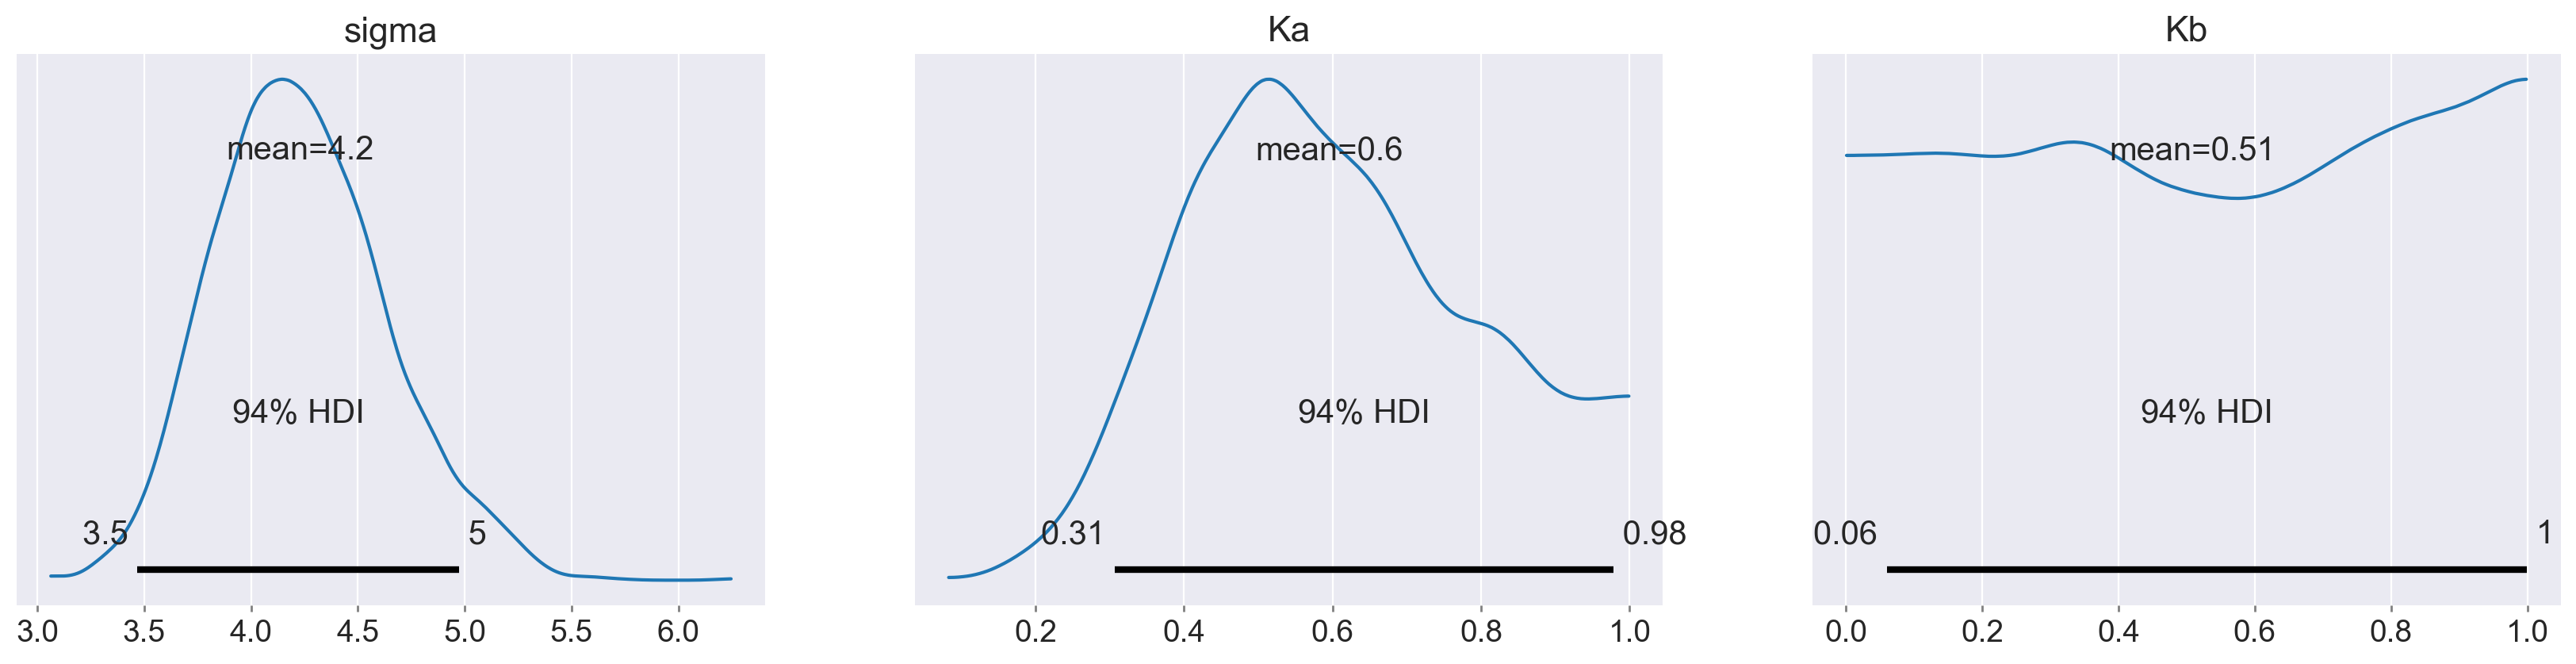

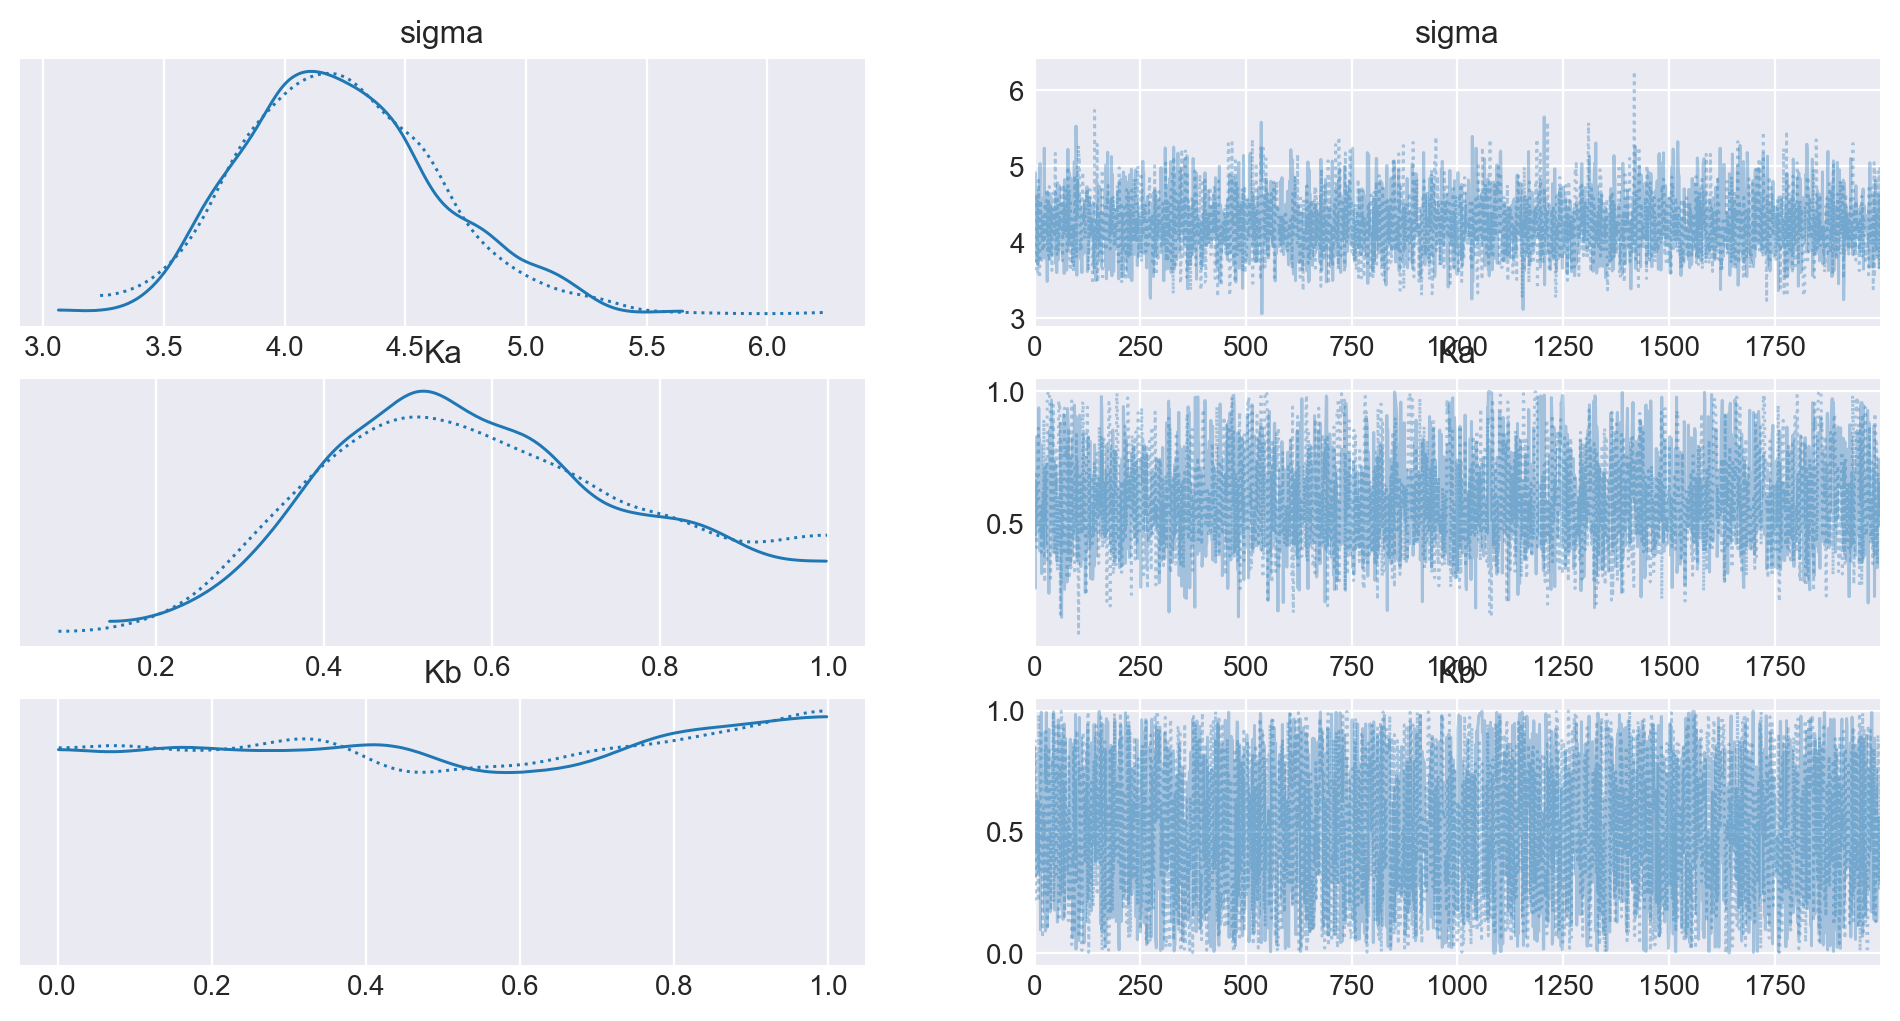

In [11]:
#data = az.from_pymc3(trace=trace)
print(trace["sigma"])
print(type(trace))
az.plot_posterior(data)
az.plot_trace(data)
az.summary(data)

array([[<AxesSubplot:ylabel='sigma'>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='Ka'>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='init', ylabel='Kb'>,
        <AxesSubplot:xlabel='sigma'>, <AxesSubplot:xlabel='Ka'>]],
      dtype=object)

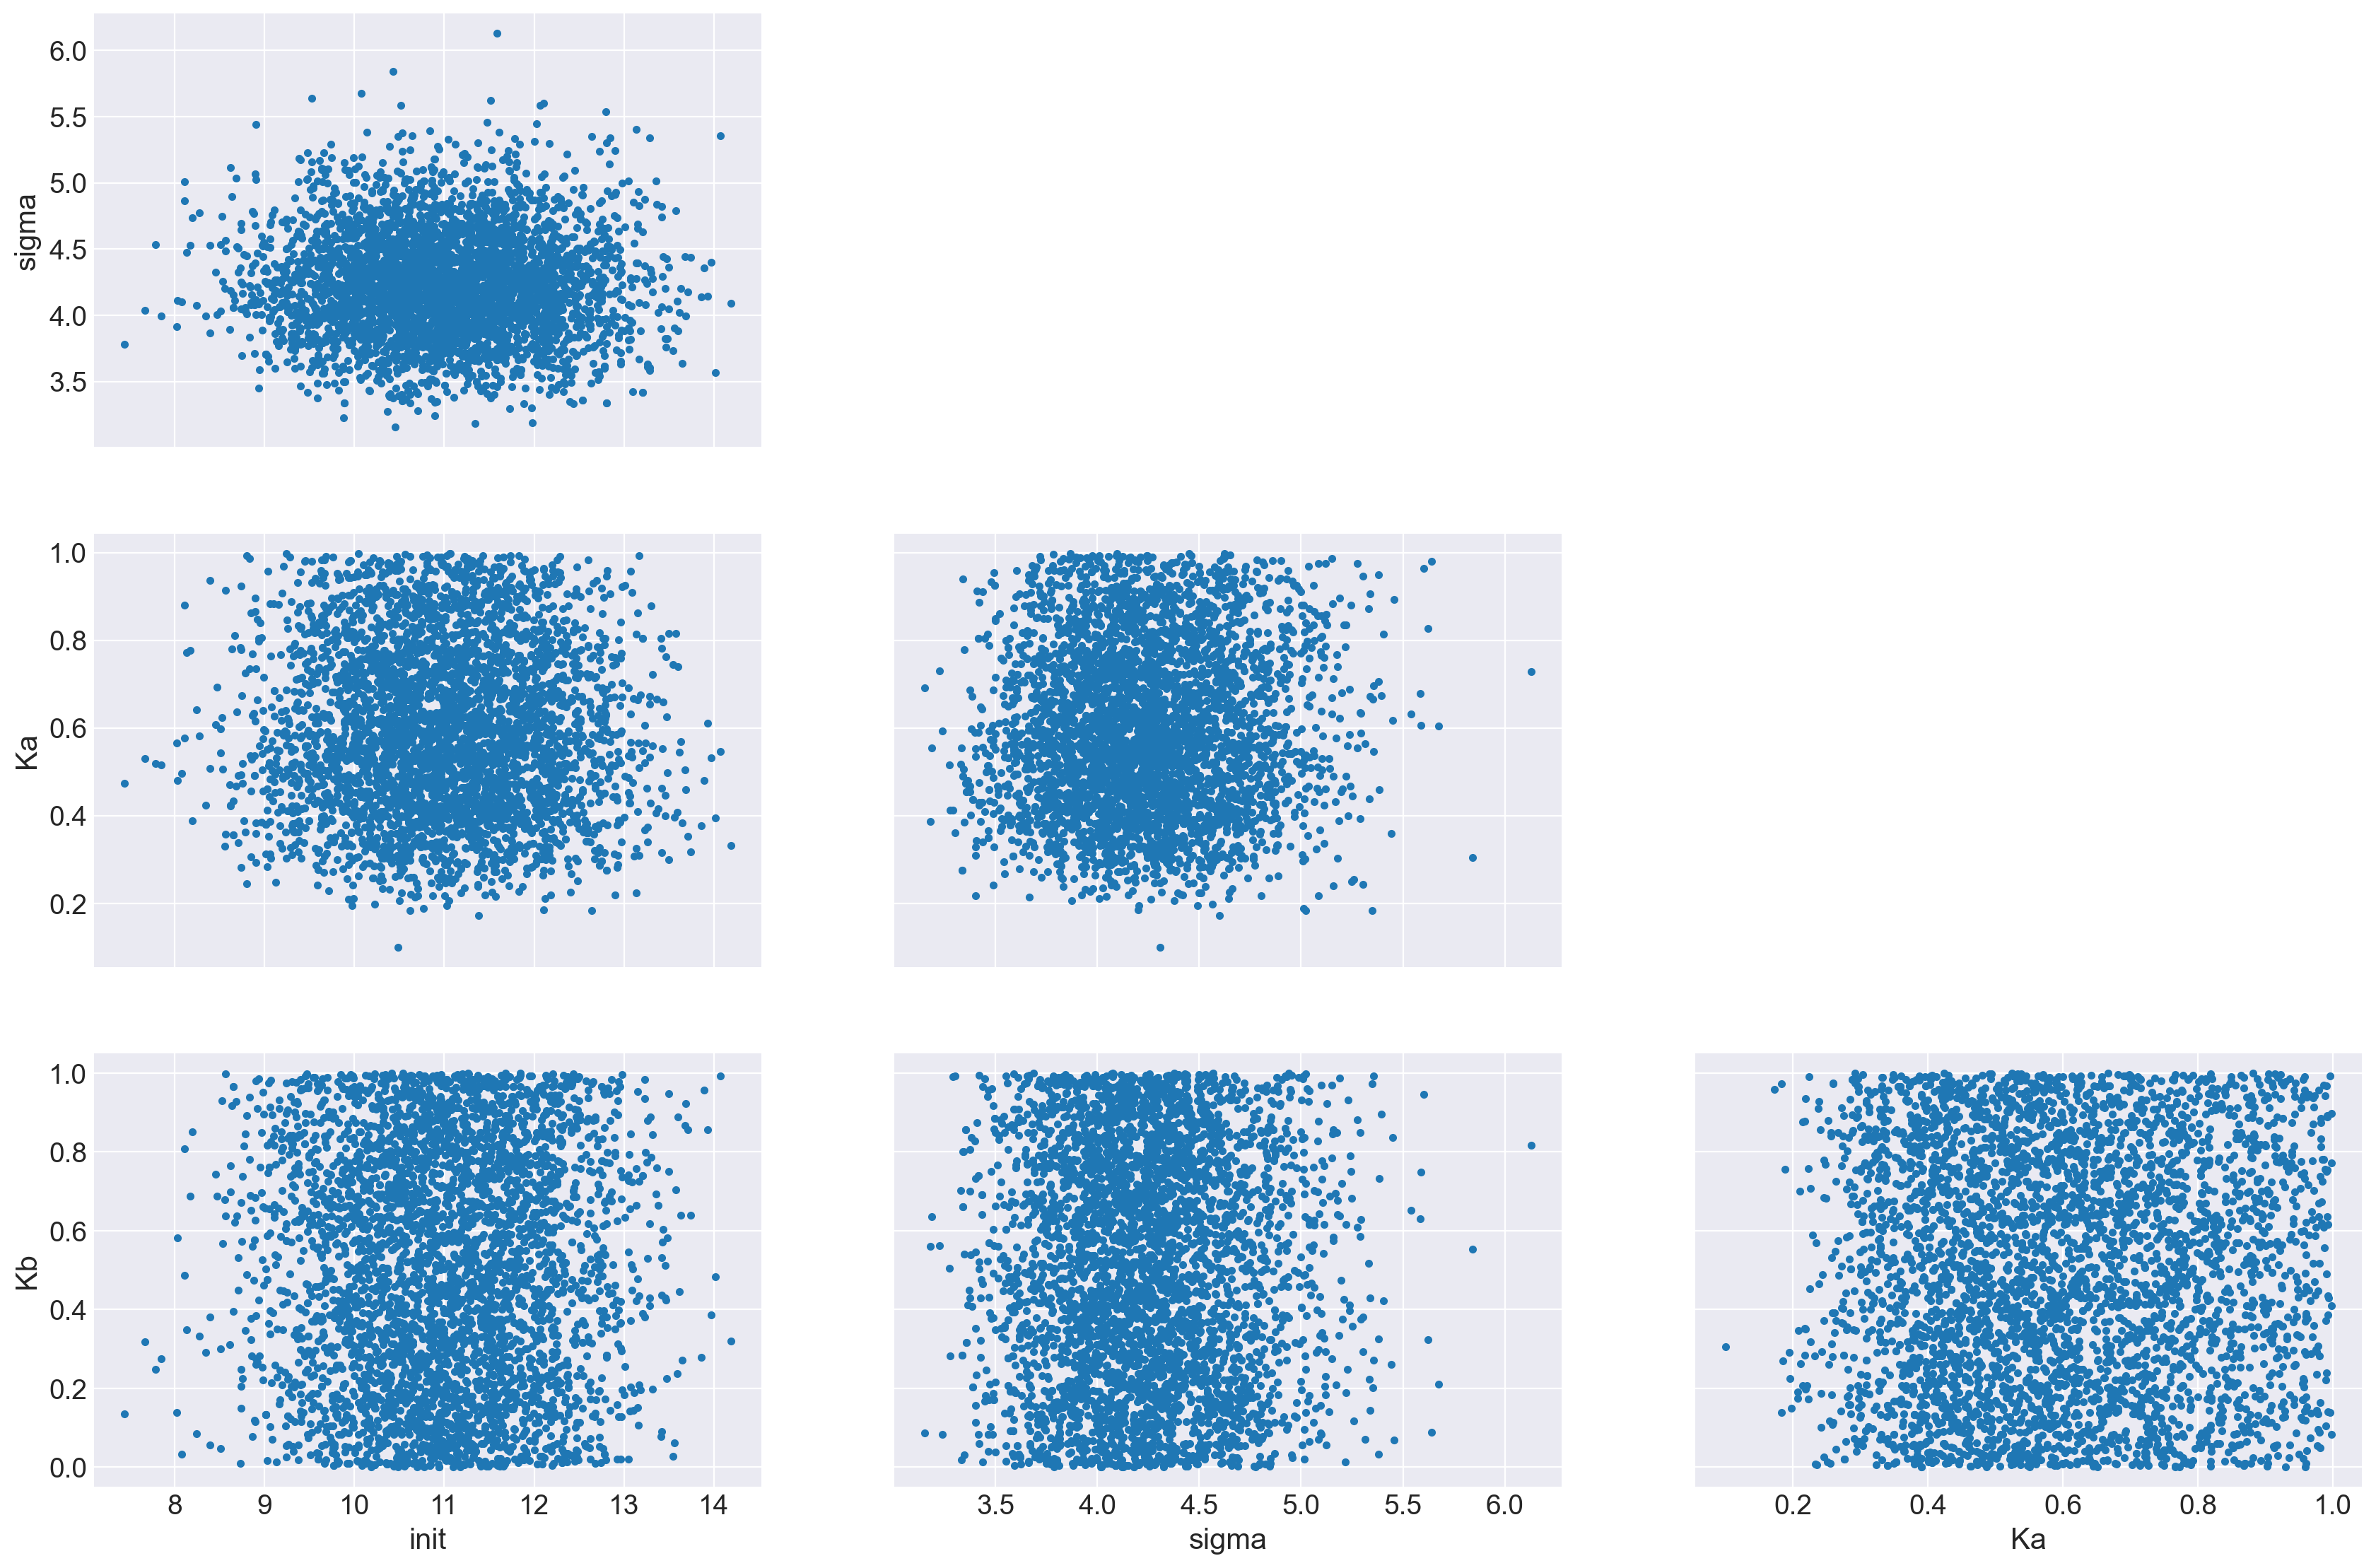

In [9]:
az.plot_pair(data)

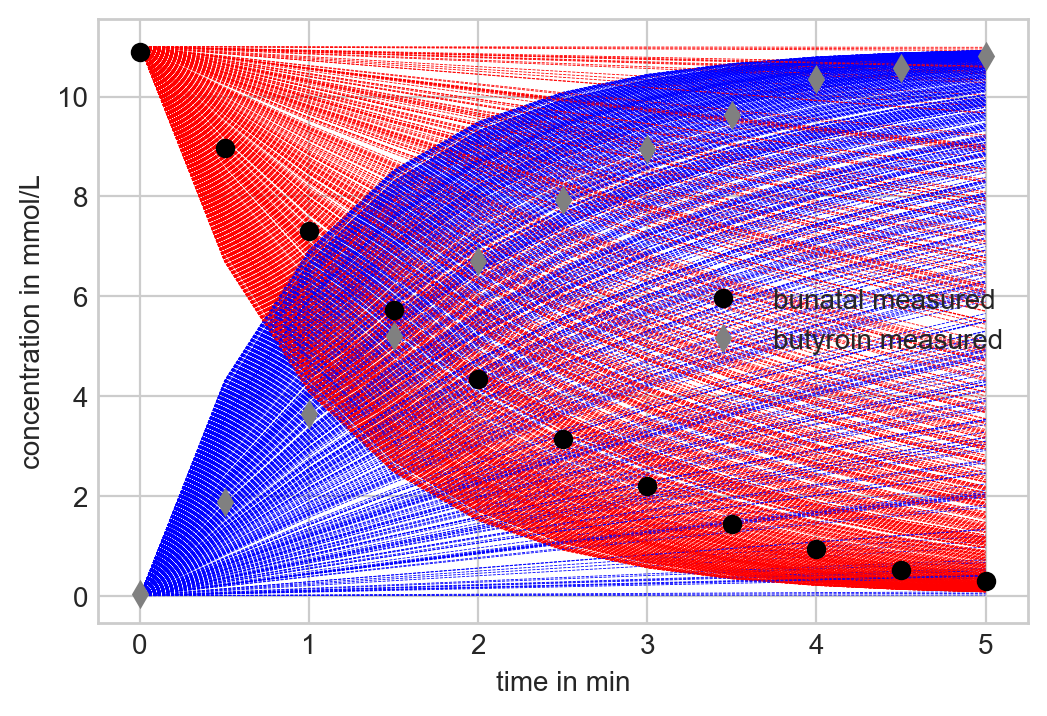

In [48]:
from scipy.integrate import odeint
fig, pri = plt.subplots()
plt.style.use(['seaborn-whitegrid'])
plt.rcParams['lines.linewidth'] = 1

def dxdt(kA, kP, A,P, t):
    dadt = -kA*A + kP*P
    return dadt

def dbdt(kA, kP, A, P, t):
        dbdt = kA*A - kP*P 
        return dbdt

def dglsys(init_cond_array, t, kA, kP):
    A = init_cond_array[0]
    P = init_cond_array[1]
    dAdt = dxdt(kA, kP, A, P, t)
    dBdt = dbdt(kA, kP, A, P,t)
    dZdt = np.array([dAdt, dBdt])
    return dZdt

for i,j in zip(prior["Ka"],prior["Kb"]):
    sol = odeint(dglsys, [11,0], time_before_feed, args=(i, j))
    #sol = odeint(dadt, [11,0], time_before_feed, args=(i, j))

    pri.plot(time_before_feed, sol[:,1], linestyle="--", linewidth=0.3, color="blue")
    pri.plot(time_before_feed, sol[:,0], linestyle="--", linewidth=0.3, color="red")
    
pri.plot(time_before_feed, substrate_before_feed, label="bunatal measured", color="black", linestyle="", marker="o")
pri.plot(time_before_feed, product_before_feed, label="butyroin measured", color="grey", linestyle="", marker="d")
pri.set_xlabel("time in min")
pri.set_ylabel("concentration in mmol/L")
pri.legend()

# Mit dem prior predictive check überprüft man erst mal was das modell in Kombination mit dem Prior zulässt. Das heisst man überprüft einfach nur, welchen Bereich kann ich mit meinem Prior abdecken.
# In der Regel kennt man die Daten nicht bevor man das Modell definiert hat
# Man gibt den Mean und die 94 % HDI interval an


In [14]:
mus = [ 0, 6,-5]
sigmas = [ 1, 1.5, 3]
N = 1000
ps = [.2, .5,.3]

y = np.hstack([np.random.normal(mus[0], sigmas[0], int(ps[0]*N)),
    np.random.normal(mus[1], sigmas[1], int(ps[1]*N)),
    np.random.normal(mus[2], sigmas[2], int(ps[2]*N))])

print(np.shape(y))

(1000,)


In [15]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt

rng = np.random.default_rng()



In [ ]:
az.style.use("arviz-darkgrid")

In [17]:
df_rugby = pd.read_csv(pm.get_data('rugby.csv'), index_col=0)
home_idx, teams = pd.factorize(df_rugby["home_team"], sort=True)
away_idx, _ = pd.factorize(df_rugby["away_team"], sort=True)


coords = {
    "team": teams,
    "match": np.arange(60),
    "field": ["home", "away"],
}
with pm.Model(coords=coords) as rugby_model:
    # global model parameters
    home = pm.Flat('home')
    sd_att = pm.HalfStudentT('sd_att', nu=3, sigma=2.5)
    sd_def = pm.HalfStudentT('sd_def', nu=3, sigma=2.5)
    intercept = pm.Flat('intercept')

    # team-specific model parameters
    atts_star = pm.Normal("atts_star", mu=0, sigma=sd_att, dims="team")
    defs_star = pm.Normal("defs_star", mu=0, sigma=sd_def, dims="team")

    atts = pm.Deterministic('atts', atts_star - tt.mean(atts_star), dims="team")
    defs = pm.Deterministic('defs', defs_star - tt.mean(defs_star), dims="team")
    home_theta = tt.exp(intercept + home + atts[home_idx] + defs[away_idx])
    away_theta = tt.exp(intercept + atts[away_idx] + defs[home_idx])

    # likelihood of observed data
    points = pm.Poisson(
        'home_points', 
        mu=tt.stack((home_theta, away_theta)).T, 
        observed=df_rugby[["home_score", "away_score"]],
        dims=("match", "field")
    )
    rugby_trace = pm.sample(1000, tune=1000, cores=4)

c:\Users\SMalz\anaconda3\lib\site-packages\ipykernel_launcher.py:34: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [defs_star, atts_star, intercept, sd_def, sd_att, home]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [19]:
#print(rugby_trace)
print(rugby_trace["atts"])


[[ 0.19822758 -0.11884537  0.13514213 -0.34145321 -0.11815848  0.24508735]
 [ 0.23317717 -0.08993704  0.15146288 -0.44713163 -0.09496668  0.2473953 ]
 [ 0.29189284 -0.05433776  0.07753145 -0.29207726 -0.09870884  0.07569958]
 ...
 [ 0.27503581 -0.03786781  0.12518695 -0.4200231  -0.15641555  0.21408371]
 [ 0.2961748   0.02231272  0.11399169 -0.43917646 -0.12358795  0.1302852 ]
 [ 0.23316825 -0.15340845  0.09139074 -0.33621744 -0.08340595  0.24847285]]
